In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats
import scipy.integrate as integrate
import statsmodels.graphics.gofplots as sgg
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KernelDensity
%matplotlib inline
#%matplotlib tk

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be r

In [2]:
my_data = pd.read_csv('/home/lin/教材/Financial_data/data/finance_M4/my_fx_data', header = None, usecols = [1], names = ['price'])

In [3]:
logR = np.log(my_data).diff()
logR.drop(logR.index[0], inplace = True)
logR.describe()

,price
count,4196.000000
mean,0.000267
std,0.012079
min,-0.149340
25%,-0.005606
50%,0.000742
75%,0.006732
max,0.060968


In [4]:
test_set = logR[-252 :]
training_set = logR[: -252]

In [5]:
posiR = training_set[training_set > 0].dropna()
negaR = training_set[training_set <= 0].dropna()
sortedPosiR = posiR['price'].sort_values()
sortedNegaR = (-negaR['price']).sort_values()
mirrorNegative = sortedNegaR.append(-sortedNegaR)
mirrorPosi = sortedPosiR.append(-sortedPosiR)
numObs = training_set['price'].count()

In [6]:
np.unique(negaR <= 0)

array([ True])

In [7]:
np.unique(posiR > 0)

array([ True])

In [8]:
mu_log = np.mean(training_set['price'])
sigma_log = np.std(training_set['price'])
t_para = stats.t.fit(training_set['price'], loc = mu_log, scale = sigma_log)
posi_t_para = stats.t.fit(mirrorPosi)
nega_t_para = stats.t.fit(mirrorNegative)
gen_para = stats.genextreme.fit(training_set['price'], loc = mu_log, scale = sigma_log)
nega_gen_para = stats.genpareto.fit(sortedNegaR, loc = mu_log, scale = sigma_log)
posi_gen_para = stats.genpareto.fit(sortedPosiR, loc = mu_log, scale = sigma_log)

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2062: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2306: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


histgram of whole set plotted with whole set fitted gen extreme, t, normal


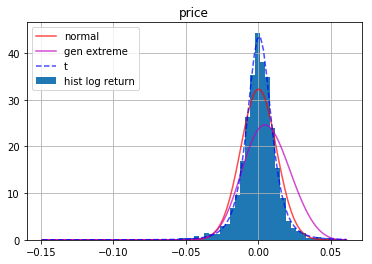

In [9]:
print('histgram of whole set plotted with whole set fitted gen extreme, t, normal')
#%matplotlib inline
#%matplotlib qt
numbins = int(60) 
training_set.hist(bins = numbins, normed=True)

x_ticks = np.linspace(min(training_set['price']), max(training_set['price']),100)
plt.plot(x_ticks, 1./((2.*np.pi)**0.5 *sigma_log)*np.exp(-((x_ticks - mu_log)/sigma_log)**2/2), 'r', alpha = 0.7)
plt.plot(x_ticks, (stats.genextreme.pdf(x_ticks, c =gen_para[0] , loc = gen_para[1], scale = gen_para[2])), 'm', alpha = 0.7)
plt.plot(x_ticks, (stats.t.pdf(x_ticks, df = t_para[0] , loc = t_para[1], scale = t_para[2])), '--b', alpha = 0.7)
plt.legend(['normal', 'gen extreme', 't', 'hist log return'])

loglog halves with whole_gen_extreme and gen_pareto and normal


(0.0004, 1.05)

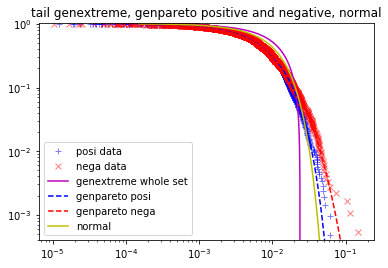

In [10]:
print('loglog halves with whole_gen_extreme and gen_pareto and normal')
plt.figure()
domain = np.linspace(max(abs(training_set['price']))/1000, max(abs(training_set['price'])), 1000)
plt.loglog(sortedPosiR, 1 - (range(1, sortedPosiR.count() + 1))/(sortedPosiR.count() + 1), '+b', alpha = 0.5)
plt.loglog(sortedNegaR, 1 - (range(1, sortedNegaR.count() + 1))/(sortedNegaR.count() + 1), 'xr', alpha = 0.5)
plt.loglog(domain, 1 - (stats.genextreme.cdf(domain, c =gen_para[0] , loc = gen_para[1], scale = gen_para[2]) - 0.365) * 2, 'm')
plt.loglog(domain, 1 - (stats.genpareto.cdf(domain, c =posi_gen_para[0] , loc = posi_gen_para[1], scale = posi_gen_para[2])), '--b')
plt.loglog(domain, 1 - (stats.genpareto.cdf(domain, c =nega_gen_para[0] , loc = nega_gen_para[1], scale = nega_gen_para[2])), '--r')
plt.loglog(domain, 1 - (stats.norm.cdf(domain, mu_log, sigma_log) - 0.5) * 2, 'y')
plt.title('tail genextreme, genpareto positive and negative, normal')
plt.legend(['posi data', 'nega data', 'genextreme whole set', 'genpareto posi', 'genpareto nega', 'normal'], loc = 3)
plt.ylim([4e-4, 1.05])

loglog halves with whole_t and mirror_fitted_t and normal


(0.0001, 1.05)

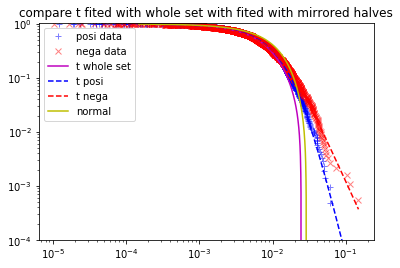

In [13]:
print('loglog halves with whole_t and mirror_fitted_t and normal')

#%matplotlib tk
plt.figure()
domain = np.linspace(max(abs(training_set['price']))/1000, max(abs(training_set['price'])), 1000)
plt.loglog(sortedPosiR, 1 - (range(1, sortedPosiR.count() + 1))/(sortedPosiR.count() + 1), '+b', alpha = 0.5)
plt.loglog(sortedNegaR, 1 - (range(1, sortedNegaR.count() + 1))/(sortedNegaR.count() + 1), 'xr', alpha = 0.5)
plt.loglog(domain, 1 - (stats.t.cdf(domain, df =t_para[0] , loc = t_para[1], scale = t_para[2]) - 0.474) * 2, 'm')
plt.loglog(domain, 1 - (stats.t.cdf(domain, df =posi_t_para[0] , loc = posi_t_para[1], scale = posi_t_para[2]) - 0.5) * 2, '--b')
plt.loglog(domain, 1 - (stats.t.cdf(domain, df =nega_t_para[0] , loc = nega_t_para[1], scale = nega_t_para[2]) - 0.5) * 2, '--r')

plt.loglog(domain, 1 - (stats.norm.cdf(domain, mu_log, sigma_log) - 0.49) * 2, 'y')
plt.title('compare t fited with whole set with fited with mirrored halves')
plt.legend(['posi data', 'nega data', 't whole set', 't posi', 't nega', 'normal'])
plt.ylim([1e-4, 1.05])

histgram of whole set plotted with whole set fitted t, mirror_fitted_t, and halves with gen pareto


NameError: name 'domain' is not defined

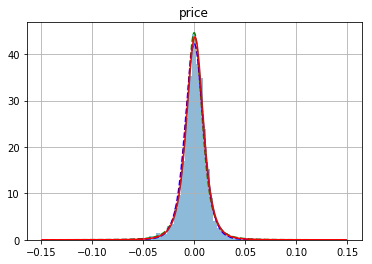

In [11]:
print('histgram of whole set plotted with whole set fitted t, mirror_fitted_t, and halves with gen pareto')
#%matplotlib tk
numbins = int(60) 
training_set.hist(bins = numbins, normed=True, alpha = 0.5)
x_ticks = np.linspace(min(training_set['price']), max(abs(training_set['price'])),2000)
plt.plot(x_ticks, (stats.t.pdf(x_ticks, df = nega_t_para[0] , loc = nega_t_para[1], scale = nega_t_para[2])), '--g')
plt.plot(x_ticks, (stats.t.pdf(x_ticks, df = posi_t_para[0] , loc = posi_t_para[1], scale = posi_t_para[2])), '--b')
plt.plot(x_ticks, (stats.t.pdf(x_ticks, df = t_para[0] , loc = t_para[1], scale = t_para[2])), 'r', )
plt.plot(domain, 0.5 *(stats.genpareto.pdf(domain, c =posi_gen_para[0] , loc = posi_gen_para[1], scale = posi_gen_para[2])), '--m')
plt.plot(-domain, 0.5 *(stats.genpareto.pdf(domain, c =nega_gen_para[0] , loc = nega_gen_para[1], scale = nega_gen_para[2])), '--k')
plt.legend(['negetive_t', 'positive_t', 'whole set t', 'posi gen', 'negative gen', 'hist log return'])

In [9]:
def sensitivity_test(n):
    green_one_domain = x_ticks[x_ticks < -0.0547887 * (1 + n)]
    green_one_pdf = stats.t.pdf(green_one_domain, df = nega_t_para[0] , loc = nega_t_para[1], scale = nega_t_para[2])
    black_two_domain = np.flip(-domain[(-domain >= -0.0547887 * (1 + n)) & (-domain < -0.015666 * (1 + n))], 0)
    black_two_pdf = 0.5 *(stats.genpareto.pdf(-black_two_domain, c =nega_gen_para[0] , loc = nega_gen_para[1], scale = nega_gen_para[2]))

    green_three_domain = x_ticks[(x_ticks >= -0.015666 * (1 + n)) & (x_ticks < 0.00174923 * (1 - n))]
    green_three_pdf = stats.t.pdf(green_three_domain, df = nega_t_para[0] , loc = nega_t_para[1], scale = nega_t_para[2])

    red_four_domain = x_ticks[(x_ticks >= 0.00174923 * (1 - n)) & (x_ticks < 0.028755 * (1 - n))]
    red_four_pdf = stats.t.pdf(red_four_domain, df = t_para[0] , loc = t_para[1], scale = t_para[2])

    green_five_domain = x_ticks[x_ticks >= 0.028755 * (1 - n)]
    green_five_pdf = stats.t.pdf(green_five_domain, df = nega_t_para[0] , loc = nega_t_para[1], scale = nega_t_para[2])

    merged_domain = np.append(green_one_domain, black_two_domain)
    merged_domain = np.append(merged_domain, green_three_domain)
    merged_domain = np.append(merged_domain, red_four_domain)
    merged_domain = np.append(merged_domain, green_five_domain)


    merged_pdf = np.append(green_one_pdf, black_two_pdf)
    merged_pdf = np.append(merged_pdf, green_three_pdf)
    merged_pdf = np.append(merged_pdf, red_four_pdf)
    merged_pdf = np.append(merged_pdf, green_five_pdf)

    total_area = integrate.trapz(merged_pdf, merged_domain, dx = 0.01)

    integrate.trapz(merged_pdf/total_area, merged_domain, dx = 0.01)

    final_pdf = merged_pdf/total_area

    alpha_one = 0.95
    alpha_two = 0.99
    i = 0
    while integrate.trapz(final_pdf[: i], merged_domain[: i], dx = 0.001) <= (1 - alpha_one):
        i += 1
    index_var_one = i
    var_one = merged_domain[index_var_one]

    i = 0
    while integrate.trapz(final_pdf[: i], merged_domain[: i], dx = 0.001) <= (1 - alpha_two):
        i += 1
    index_var_two = i
    var_two = merged_domain[index_var_two]

    alpha_ES = 0.975
    i = 0
    while integrate.trapz(final_pdf[: i], merged_domain[: i], dx = 0.001) <= (1 - alpha_ES):
        i += 1
    index_ES = i
    ES_domain = merged_domain[: index_ES]
    ES_pdf = final_pdf[: index_ES]
    to_integral = ES_domain * ES_pdf
    ES = integrate.trapz(to_integral, ES_domain, dx = 0.001) / (1 - alpha_ES)

    print(var_one)

    print(var_two)

    print(ES)
    
    return '|' + '|'.join(map(str, (var_one, var_two, ES))) + '|'

In [20]:
sensitivity_test(0.05)

-0.020459515558606166
-0.037932240524715076
-0.0409199925753798


'|-0.020459515558606166|-0.037932240524715076|-0.0409199925753798|'

In [21]:
sensitivity_test(-0.05)

-0.020459515558606166
-0.037932240524715076
-0.04091433935803336


'|-0.020459515558606166|-0.037932240524715076|-0.04091433935803336|'

In [22]:
sensitivity_test(0.1)

-0.020459515558606166
-0.037932240524715076
-0.04125209134082783


'|-0.020459515558606166|-0.037932240524715076|-0.04125209134082783|'

In [23]:
sensitivity_test(-0.1)

-0.020459515558606166
-0.03778290099509021
-0.04121393468613737


'|-0.020459515558606166|-0.03778290099509021|-0.04121393468613737|'

In [ ]:
sensitivity_test(0)

In [24]:
sensitivity_test(0.15)

-0.020459515558606166
-0.03778290099509021
-0.041163228731784414


'|-0.020459515558606166|-0.03778290099509021|-0.041163228731784414|'

In [25]:
sensitivity_test(-0.15)

-0.020459515558606166
-0.03778290099509021
-0.04102934512352348


'|-0.020459515558606166|-0.03778290099509021|-0.04102934512352348|'

In [14]:
sensitivity_test(-0.2)

-0.020459515558606166
-0.037484221935840494
-0.04073922350506344


'|-0.020459515558606166|-0.037484221935840494|-0.04073922350506344|'

In [15]:
sensitivity_test(0.2)

-0.020459515558606166
-0.03778290099509021
-0.04105675879949472


'|-0.020459515558606166|-0.03778290099509021|-0.04105675879949472|'

In [ ]:
l